In [1]:
import pickle
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam



In [2]:
# from collections import Counter

# def is_image_file(filename):
#     """Check if a file is an image based on its extension."""
#     valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
#     return any(filename.lower().endswith(ext) for ext in valid_extensions)

# def find_top_classes(base_path, top_n=100):
#     """Find the top N classes with the most image files."""
#     class_image_count = {}

#     for class_name in os.listdir(base_path):
#         class_path = os.path.join(base_path, class_name)

#         if os.path.isdir(class_path):  # Ensure it's a directory
#             # Count image files in the class directory
#             image_count = sum(
#                 is_image_file(filename)
#                 for filename in os.listdir(class_path)
#             )
#             class_image_count[class_name] = image_count

#     # Get the top N classes
#     top_classes = Counter(class_image_count).most_common(top_n)
#     return top_classes

# # Base path to the directory containing the 10,500 classes
# base_directory = "/kaggle/input/casia-webface/datasets"

# # Find the top 100 classes
# top_50_classes = find_top_classes(base_directory, top_n=50)

# # Print the results
# print("Top 50 classes with the most images:")
# for rank, (class_name, count) in enumerate(top_50_classes, start=1):
#     print(f"{rank}. {class_name}: {count} images")

# with open('/kaggle/working/top100class.pkl', 'wb') as f:
#     pickle.dump(top_50_classes, f)



In [3]:
import os
from collections import defaultdict
from pathlib import Path

# Set of supported image file extensions
IMAGE_EXTENSIONS = '.jpg'

def count_images_in_directory(base_dir):
    """
    Traverse the base directory recursively and count image files in each subdirectory.
    Returns a dictionary mapping directory paths to image counts.
    """
    image_counts = defaultdict(int)
    
    for root, dirs, files in os.walk(base_dir):
        count = sum(1 for f in files if Path(f).suffix.lower() == IMAGE_EXTENSIONS)
        if count > 0:
            image_counts[root] = count
            
    return image_counts

def get_top_image_dirs(base_dir, top_n=100):
    """
    Returns the top_n directories under base_dir that contain the most image files.
    """
    image_counts = count_images_in_directory(base_dir)
    top_dirs = sorted(image_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_dirs

# Example usage:
base_dir = '/kaggle/input/casia-webface/datasets'  # Replace with your path
top_100_classes = get_top_image_dirs(base_dir)


In [4]:
with open('/kaggle/input/d/seragehab/top100class/top100class.pkl', 'rb') as f:
    top_100_classes = pickle.load(f)


In [5]:
# Display results in the notebook
sum = 0
for i, (dir_path, count) in enumerate(top_100_classes, 1):
    print(f"{i:3}. {dir_path} --> {count} images")
    sum += count
print(f"The total number of images in the top 100 classes is {sum}")


  1. /kaggle/input/casia-webface/datasets/0004266 --> 768 images
  2. /kaggle/input/casia-webface/datasets/0000439 --> 705 images
  3. /kaggle/input/casia-webface/datasets/0519456 --> 687 images
  4. /kaggle/input/casia-webface/datasets/0010736 --> 631 images
  5. /kaggle/input/casia-webface/datasets/0515116 --> 628 images
  6. /kaggle/input/casia-webface/datasets/0221043 --> 603 images
  7. /kaggle/input/casia-webface/datasets/0424060 --> 593 images
  8. /kaggle/input/casia-webface/datasets/0004770 --> 589 images
  9. /kaggle/input/casia-webface/datasets/0688132 --> 587 images
 10. /kaggle/input/casia-webface/datasets/0000210 --> 578 images
 11. /kaggle/input/casia-webface/datasets/0358316 --> 573 images
 12. /kaggle/input/casia-webface/datasets/1015262 --> 569 images
 13. /kaggle/input/casia-webface/datasets/0221046 --> 568 images
 14. /kaggle/input/casia-webface/datasets/1433588 --> 562 images
 15. /kaggle/input/casia-webface/datasets/1312575 --> 542 images
 16. /kaggle/input/casia-

In [6]:
with open('/kaggle/working/top100class.pkl', 'wb') as f:
    pickle.dump((top_100_classes), f)

In [7]:
# Define the base directory
base_dir = '/kaggle/input/casia-webface/datasets'

# Initialize data and labels lists
data = []
lables = []

# Loop through each subdirectory (class) in the base directory
for class_name in top_100_classes[:50] :
    class_dir = os.path.join(base_dir, str(class_name[0]))
    if (top_100_classes.index(class_name) + 1)%10 == 0: print(f"handling class number {top_100_classes.index(class_name) + 1}")
    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Loop through each image in the class directory
        for image_name in os.listdir(class_dir)[:200]:
            image_path = os.path.join(class_dir, image_name)
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            image = cv2.resize(image , (112 , 112))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image is not None:
                # Append the image data and its label
                data.append(image)
                lables.append(class_name)

# Convert lists to numpy arrays for further processing
data = np.array(data)
lables = np.array(lables)

with open('/kaggle/working/data.pkl', 'wb') as f:
    pickle.dump((data,lables), f)

# Print summary
# print(f"Loaded {len(data)} images with labels: {set(labels)}")


handling class number 10
handling class number 20
handling class number 30
handling class number 40
handling class number 50


## fokk mn ally ta7t dy ##
 


In [ ]:
# Normalize images in batches and ensure float32
def normalize_images_per_image(images):
    normalized_images = np.zeros_like(images, dtype=np.float32)
    for i,image in enumerate(images):
        mean = np.mean(image)
        std = np.std(image)
        normalized_images[i] = ( image - mean ) / std 
        if i%500==0:
            print(i)
    normalized_images =  normalized_images.astype(np.float32)
    # print(normalized_images.shape)
    return normalized_images  # Ensure float32

def normalize_images_in_batches(images, batch_size):
    normalized_images = np.zeros_like(images, dtype=np.float32)
    for i in range(0, len(images) ,batch_size):
        images_batch = images[i:i+batch_size] if i+batch_size < len(images) else images[i:len(images)]
        mean = np.mean(images_batch)
        std = np.std(images_batch)
        normalized_images_batch = ( images_batch - mean ) / std 
        normalized_images[i:i+len(images_batch)] = normalized_images_batch 
        if i%500==0:
            print(i)
    normalized_images =  normalized_images.astype(np.float32)
    print(normalized_images.shape)
    return normalized_images  # Ensure float32



# Normalize images
normalized_images = normalize_images_in_batches(data,7000)




with open('/kaggle/working/normalized_images.pkl', 'wb') as f:
    pickle.dump(normalized_images, f)

In [8]:
print(data.shape)

total_samples = data.shape[0]
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size  # To ensure all samples are used

# Shuffle data
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(total_samples)

# Split the data
train_indices = indices[-train_size:]
val_indices = indices[:val_size]
test_indices = indices[val_size:val_size+test_size]

train_data = data[train_indices]
val_data = data[val_indices]
test_data = data[test_indices]

train_lables = lables[train_indices]
val_lables = lables[val_indices]
test_lables = lables[test_indices]

training_mean = train_data.mean(axis=(0,1,2))
training_std = train_data.std(axis=(0,1,2))

train_data_norm = (train_data - training_mean)/ training_std
val_data_norm = (val_data - training_mean)/ training_std
test_data_norm = (test_data - training_mean)/ training_std

print(train_data.shape)


(10000, 112, 112, 3)
(7000, 112, 112, 3)


In [9]:
with open('/kaggle/working/data.pkl', 'rb') as f:
    data,lables = pickle.load(f)

In [ ]:
with open('/kaggle/working/normalized_images.pkl', 'rb') as f:
    normalized_images = pickle.load(f)

In [ ]:
# with open('/kaggle/input/ci-milestone2/data.pkl', 'rb') as f:
#     data,labels = pickle.load(f)

In [ ]:
# with open('/kaggle/input/ci-milestone2/normalized_images.pkl', 'rb') as f:
#     normalized_images = pickle.load(f)

[67.15667533 56.62661301 53.92647834]


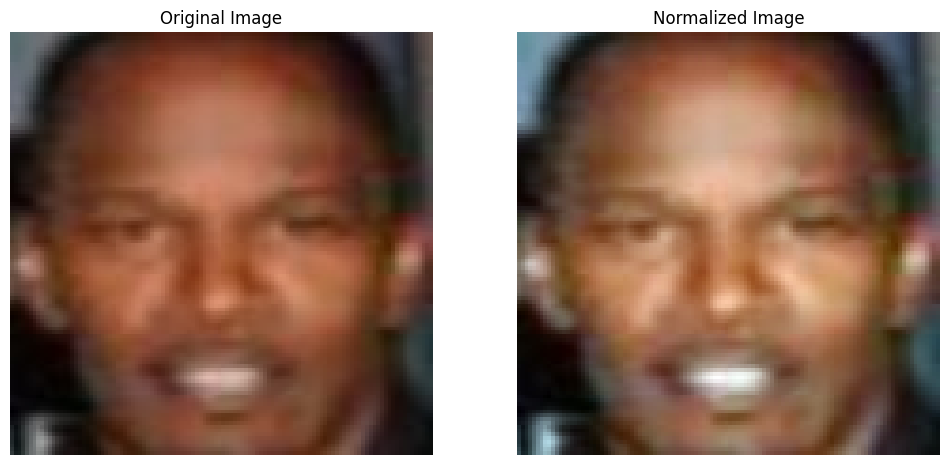

In [10]:
print(training_std)
# Randomly choose an image index to visualize
sample_idx = np.random.choice(train_data.shape[0])

sample_image = train_data[sample_idx]

normalized_sample_image = train_data_norm[sample_idx]
# Compute min and max per channel
c_min = normalized_sample_image.min(axis=(0,1), keepdims=True)
c_max = normalized_sample_image.max(axis=(0,1), keepdims=True)

# Scale each channel independently to [0,1]
normalized_sample_image = (normalized_sample_image - c_min) / (c_max - c_min + 1e-8)
# normalized_sample_image = (normalized_sample_image - normalized_sample_image.min()) / (normalized_sample_image.max() - normalized_sample_image.min())

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sample_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(normalized_sample_image)
ax[1].set_title('Normalized Image')
ax[1].axis('off')

plt.show()

In [11]:
# Calculate split sizes

# total_samples = normalized_images.shape[0]
# train_size = int(0.7 * total_samples)
# val_size = int(0.15 * total_samples)
# test_size = total_samples - train_size - val_size  # To ensure all samples are used

# # Shuffle data
# np.random.seed(42)  # For reproducibility
# indices = np.random.permutation(total_samples)

# # Split the data
# train_indices = indices[-train_size:]
# val_indices = indices[:val_size]
# test_indices = indices[val_size:val_size+test_size]

# train_data = normalized_images[train_indices]
# val_data = normalized_images[val_indices]
# test_data = normalized_images[test_indices]

# Output shapes
print("Training data shape:", train_data_norm.shape)
print("Validation data shape:", val_data_norm.shape)
print("Testing data shape:", test_data_norm.shape)

def generator():
    for x, y in zip(train_data_norm, train_data_norm):
        yield x, y


batch_size = 32
# train_dataset = (
#     tf.data.Dataset.from_tensor_slices((train_data, train_data))
#     .batch(batch_size)
#     .shuffle(1000)
#     .prefetch(tf.data.AUTOTUNE)
# )

train_dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(112, 112, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(112, 112, 3), dtype=tf.float32),
    )
).batch(batch_size).shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_data_norm, val_data_norm))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_data_norm, test_data_norm))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)




Training data shape: (7000, 112, 112, 3)
Validation data shape: (1500, 112, 112, 3)
Testing data shape: (1500, 112, 112, 3)


In [12]:
# Convolutional Autoencoder model definition
def convolutional_autoencoder(input_shape):
    print(f"Input shape: {input_shape}")
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    # x = tf.keras.layers.Dropout(0.05)(x)  # Dropout after first block

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    # x = tf.keras.layers.Dropout(0.05)(x)  # Dropout after second block

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    # x = tf.keras.layers.Dropout(0.05)(x)  # Dropout after third block

    # Latent space
    latent_space = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="latent_space")(x)

    # Decoder
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(latent_space)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    # x = tf.keras.layers.Dropout(0.05)(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    # x = tf.keras.layers.Dropout(0.05)(x)

    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    # x = tf.keras.layers.Dropout(0.05)(x)

    outputs = tf.keras.layers.Conv2DTranspose(input_shape[-1], (3, 3), activation='linear', padding='same')(x)

    autoencoder = tf.keras.Model(inputs, outputs, name="Convolutional_Autoencoder")
    encoder = tf.keras.Model(inputs, latent_space, name="Encoder")

    return autoencoder, encoder

In [13]:
input_shape = (112, 112, 3)
conv_autoencoder, conv_encoder = convolutional_autoencoder(input_shape=input_shape)
conv_autoencoder.compile(optimizer='Nadam', loss='mse')  # Mean squared error

# Train the autoencoder
epochs = 120
_ = conv_autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test set
test_loss = conv_autoencoder.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
conv_autoencoder.save_weights("/kaggle/working/autoencoder.weights.h5")
print("model weights are saved ")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the history and test_loss objects
# results = [
#     conv_history , test_loss , test_accuracy
# ]

# Save the objects to a pickle file
# with open('/kaggle/working/conv_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

Input shape: (112, 112, 3)
ERROR! Session/line number was not unique in database. History logging moved to new session 29
Epoch 1/120


KeyboardInterrupt: 

In [14]:
conv_autoencoder, _ = convolutional_autoencoder(input_shape=(112, 112, 3))
conv_autoencoder.load_weights("/kaggle/input/auto-encoder-weights/autoencoder.weights.h5")

Input shape: (112, 112, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(112, 112, 3)


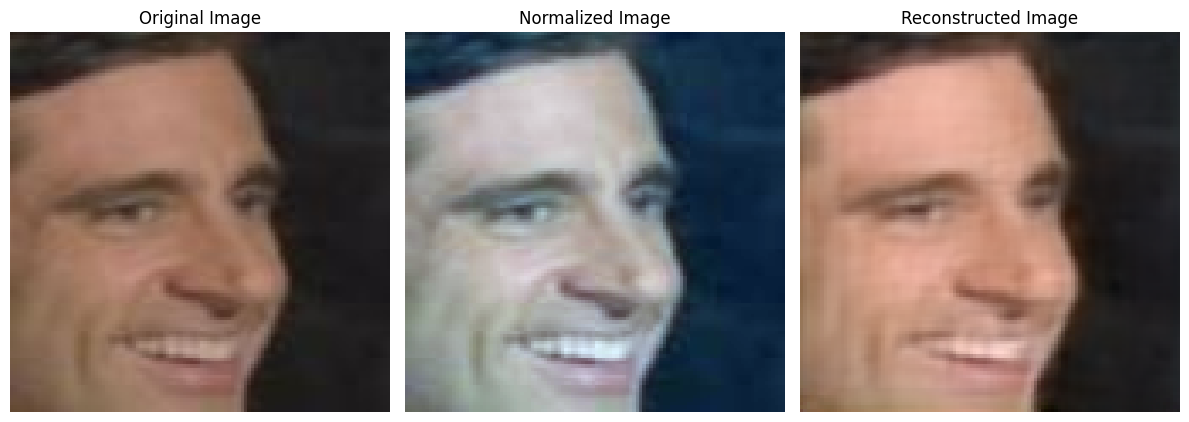

In [21]:
# Randomly choose an image index to visualize
sample_idx = np.random.choice(data.shape[0])
sample_image = train_data[sample_idx]

normalized_sample_image = train_data_norm[sample_idx]
normalized_sample_image = (normalized_sample_image - normalized_sample_image.min()) / (normalized_sample_image.max() - normalized_sample_image.min())


# Add batch dimension before passing to the model
input_image = np.expand_dims(sample_image, axis=0)  # shape becomes (1, H, W, C)

# Predict the reconstructed image
predicted_image = conv_autoencoder.predict(input_image)[0]  # Remove batch dimension
print(predicted_image.shape)
predicted_image = (predicted_image - np.min(predicted_image)) / (np.max(predicted_image) - np.min(predicted_image))

# Plot original vs. reconstructed image
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(sample_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(normalized_sample_image)
ax[1].set_title('Normalized Image')
ax[1].axis('off')

ax[2].imshow(predicted_image)
ax[2].set_title('Reconstructed Image')
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
with open('/kaggle/working/conv_results.pkl', 'rb') as f:
    results = pickle.load(f)
    [
    conv_history , test_loss , test_accuracy
    ] = results


# Print the training history
print("\nTraining History:")
print("=" * 50)
print("Training Loss over Epochs: ", conv_history.history['loss'])
print("Validation Loss over Epochs: ", conv_history.history['val_loss'])
print("Training Accuracy over Epochs: ", conv_history.history['accuracy'])
print("Validation Accuracy over Epochs: ", conv_history.history['val_accuracy'])
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("=" * 50)

In [ ]:
def set_random_seed(seed=42):
    """Set random seed for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fix hash-based randomness
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy random seed
    tf.random.set_seed(seed)  # TensorFlow random seed

    # Optional: Enable GPU determinism for reproducibility
    tf.config.experimental.enable_op_determinism()

# Set seed before training
set_random_seed(42)

def build_autoencoder_less_nodes(input_shape):
    """Build a vanilla autoencoder with fewer nodes."""
    print(f"Input shape: {input_shape}")

    # Encoder
    encoder_input = tf.keras.Input(shape=(112, 112, 3), name="encoder_input")
    flat_input = tf.keras.layers.Flatten(name="flatten_input")(encoder_input)
    dense_128_a = tf.keras.layers.Dense(128, activation='relu', name="dense_128_a")(flat_input)
    dense_128_b = tf.keras.layers.Dense(128, activation='relu', name="dense_128_b")(dense_128_a)
    dense_64 = tf.keras.layers.Dense(64, activation='relu', name="dense_64")(dense_128_b)
    latent_layer = tf.keras.layers.Dense(64, activation='relu', name="latent_layer")(dense_64)

    # Decoder
    decoder_dense_64 = tf.keras.layers.Dense(64, activation='relu', name="decoder_dense_64")(latent_layer)
    decoder_dense_128_a = tf.keras.layers.Dense(128, activation='relu', name="decoder_dense_128_a")(decoder_dense_64)
    decoder_dense_128_b = tf.keras.layers.Dense(128, activation='relu', name="decoder_dense_128_b")(decoder_dense_128_a)
    output_flat = tf.keras.layers.Dense(np.prod(input_shape), activation='linear', name="output_flat")(decoder_dense_128_b)
    output_reshaped = tf.keras.layers.Reshape(input_shape, name="output_reshaped")(output_flat)

    encoder = tf.keras.Model(encoder_input, latent_layer, name="Encoder")
    autoencoder = tf.keras.Model(inputs=encoder_input, outputs=output_reshaped, name="Autoencoder_Less_Nodes")

    return autoencoder ,encoder

def build_autoencoder_longer(input_shape):
    """Build a vanilla autoencoder with more layers."""
    print(f"Input shape: {input_shape}")

    # Encoder
    encoder_input = tf.keras.Input(shape=input_shape, name="encoder_input")
    flat_input = tf.keras.layers.Flatten(name="flatten_input")(encoder_input)
    dense_256 = tf.keras.layers.Dense(256, activation='relu', name="dense_256")(flat_input)
    dense_128 = tf.keras.layers.Dense(128, activation='relu', name="dense_128")(dense_256)
    dense_64 = tf.keras.layers.Dense(64, activation='relu', name="dense_64")(dense_128)
    latent_layer = tf.keras.layers.Dense(64, activation='relu', name="latent_layer")(dense_64)

    # Decoder
    decoder_dense_64 = tf.keras.layers.Dense(64, activation='relu', name="decoder_dense_64")(latent_layer)
    decoder_dense_128 = tf.keras.layers.Dense(128, activation='relu', name="decoder_dense_128")(decoder_dense_64)
    decoder_dense_256 = tf.keras.layers.Dense(256, activation='relu', name="decoder_dense_256")(decoder_dense_128)
    output_flat = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid', name="output_flat")(decoder_dense_256)
    output_reshaped = tf.keras.layers.Reshape(input_shape, name="output_reshaped")(output_flat)

    encoder = tf.keras.Model(encoder_input, latent_layer, name="Encoder")
    autoencoder = tf.keras.Model(inputs=encoder_input, outputs=output_reshaped, name="Autoencoder_Longer")


    return autoencoder , encoder

def build_autoencoder(input_shape):
    """Build a basic vanilla autoencoder."""
    print(f"Input shape: {input_shape}")

    # Encoder
    encoder_input = tf.keras.Input(shape=input_shape, name="encoder_input")
    flat_input = tf.keras.layers.Flatten(name="flatten_input")(encoder_input)
    dense_256 = tf.keras.layers.Dense(256, activation='relu', name="dense_256")(flat_input)
    dense_64 = tf.keras.layers.Dense(64, activation='relu', name="dense_64")(dense_256)
    latent_layer = tf.keras.layers.Dense(64, activation='relu', name="latent_layer")(dense_64)

    # Decoder
    decoder_dense_64 = tf.keras.layers.Dense(64, activation='relu', name="decoder_dense_64")(latent_layer)
    decoder_dense_256 = tf.keras.layers.Dense(256, activation='relu', name="decoder_dense_256")(decoder_dense_64)
    output_flat = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid', name="output_flat")(decoder_dense_256)
    output_reshaped = tf.keras.layers.Reshape(input_shape, name="output_reshaped")(output_flat)

    encoder = tf.keras.Model(encoder_input, latent_layer, name="Encoder")
    autoencoder = tf.keras.Model(inputs=encoder_input, outputs=output_reshaped, name="Basic_Autoencoder")

    return autoencoder , encoder



In [ ]:
# Set seed for reproducibility
set_random_seed(42)

# Part 1: Autoencoder with fewer nodes
input_shape = (112, 112, 3)
print("Training Autoencoder with Fewer Nodes")
autoencoder_less, encoder_less = build_autoencoder_less_nodes(input_shape=input_shape)  # Function name adjusted
autoencoder_less.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Mean squared error loss

# Train the autoencoder
epochs = 5
history_1 = autoencoder_less.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test set
test_loss_1 = autoencoder_less.evaluate(test_dataset)
print(f"Test Loss (Less Nodes): {test_loss_1[0]:.4f}")
print(f"Test Accuracy (Less Nodes): {test_loss_1[1]:.4f}")

# Part 2: Autoencoder with more nodes
set_random_seed(42)
print("\nTraining Autoencoder with More Nodes")
autoencoder_long, encoder_long = build_autoencoder_longer(input_shape=input_shape)  # Function name adjusted
autoencoder_long.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Mean squared error loss

# Train the autoencoder
epochs = 5
history_2 = autoencoder_long.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test set
test_loss_2 = autoencoder_long.evaluate(test_dataset)
print(f"Test Loss (More Nodes): {test_loss_2[0]:.4f}")
print(f"Test Accuracy (More Nodes): {test_loss_2[1]:.4f}")

# Part 3: Original Autoencoder
set_random_seed(42)
print("\nTraining Original Autoencoder")
autoencoder_orig, encoder_orig = build_autoencoder(input_shape=input_shape)  # Function name adjusted
autoencoder_orig.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # Mean squared error loss

# Train the autoencoder
epochs = 5
history_3 = autoencoder_orig.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

# Evaluate the model on the test set
test_loss_3 = autoencoder_orig.evaluate(test_dataset)
print(f"Test Loss (Original): {test_loss_3[0]:.4f}")
print(f"Test Accuracy (Original): {test_loss_3[1]:.4f}")


# Save the history and test_loss objects
results = [
    history_1, history_2, history_3,
    test_loss_1, test_loss_2, test_loss_3
]

# Save the objects to a pickle file
with open('/kaggle/working/autoencoder_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
with open('/kaggle/working/autoencoder_results.pkl', 'rb') as f:
    results = pickle.load(f)
    [
    history_1, history_2, history_3,
    test_loss_1, test_loss_2, test_loss_3
    ] = results

# Print the training history
print("\nSummary of Results:")
print("=" * 50)
print("Autoencoder with Fewer Nodes:")
print(f"Training Loss: {history_1.history['loss']}")
print(f"Validation Loss: {history_1.history['val_loss']}")
print(f"Training Accuracy: {history_1.history['accuracy']}")
print(f"Validation Accuracy: {history_1.history['val_accuracy']}")
print(f"Test Loss: {test_loss_1[0]:.4f}")
print(f"Test Accuracy: {test_loss_1[1]:.4f}")

print("\nAutoencoder with More Nodes:")
print(f"Training Loss: {history_2.history['loss']}")
print(f"Validation Loss: {history_2.history['val_loss']}")
print(f"Training Accuracy: {history_2.history['accuracy']}")
print(f"Validation Accuracy: {history_2.history['val_accuracy']}")
print(f"Test Loss: {test_loss_2[0]:.4f}")
print(f"Test Accuracy: {test_loss_2[1]:.4f}")

print("\nOriginal Autoencoder:")
print(f"Training Loss: {history_3.history['loss']}")
print(f"Validation Loss: {history_3.history['val_loss']}")
print(f"Training Accuracy: {history_3.history['accuracy']}")
print(f"Validation Accuracy: {history_3.history['val_accuracy']}")
print(f"Test Loss: {test_loss_3[0]:.4f}")
print(f"Test Accuracy: {test_loss_3[1]:.4f}")
print("=" * 50)



metrics = [
    ("accuracy", "Training Accuracy"), 
    ("val_accuracy", "Validation Accuracy"), 
    ("loss", "Training Loss"), 
    ("val_loss", "Validation Loss")
]
histories = [history_1, history_2, history_3]
plot_labels = ["Fewer Nodes", "More Nodes", "Original"]
epochs = range(1, len(history_1.history['accuracy']) + 1)

# Accuracy plot
plt.figure(figsize=(5, 3))
for history, label in zip(histories, plot_labels):
    for metric, description in metrics[:2]:  # Accuracy metrics
        linestyle = '--' if 'Validation' in description else '-'
        plt.plot(epochs, history.history[metric], label=f"{description} ({label})", linestyle=linestyle)

plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(5, 3))
for history, label in zip(histories, labels):
    for metric, description in metrics[2:]:  # Loss metrics
        linestyle = '--' if 'Validation' in description else '-'
        plt.plot(epochs, history.history[metric], label=f"{description} ({label})", linestyle=linestyle)

plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Assuming `images` is your dataset of shape (M, 112, 112, 3)
# M is the number of images
def eigenfaces(images, num_components=50):
    M, h, w, c = images.shape
    
    # Step 1: Flatten images
    flattened_images = images.reshape(M, -1)  # Shape: (M, 37632)
    
    # Step 2: Normalize the data
    mean_face = np.mean(flattened_images, axis=0)
    centered_images = flattened_images - mean_face
    
    # Step 3: Apply PCA
    pca = PCA(n_components=num_components)
    pca.fit(centered_images)
    eigenfaces = pca.components_  # Principal components
    
    # Step 4: Project the dataset onto the PCA subspace
    projections = pca.transform(centered_images)
    
    return eigenfaces, projections, mean_face

# Example usage:
# Convert dataset to grayscale (optional)
def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

# Your dataset
# images = load_your_images()  # Load images in shape (M, 112, 112, 3)

images = convert_to_grayscale(normalized_images).reshape(-1, 112, 112, 1)

# Run Eigenfaces
eigenfaces, projections, mean_face = eigenfaces(images, num_components=50)


In [ ]:
def train_and_evaluate_model(X, labels, num_epochs):
    # Flatten images to fit into a neural network
    X_flat = X.reshape(X.shape[0], -1)  # Flatten images from 50x37 to 1850 vector

    # Encode labels as one-hot vectors
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels[:, 0])
    y_one_hot = tf.keras.utils.to_categorical(y_encoded)

    # Step 3: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y_one_hot, test_size=0.2, random_state=42)

    # Step 4: Build the neural network model
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
        Dense(1024, activation='relu'),
        # Dropout(0.2),
        Dense(512, activation='relu'),
        # Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(y_one_hot.shape[1], activation='softmax')
    ])

    # Step 5: Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 6: Train the model and store accuracy and loss
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=256, validation_data=(X_test, y_test))

    # Store the accuracy and loss for each epoch
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Step 7: Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Step 8: Make predictions
    test_image = X_test[0].reshape(1, -1)  # Flatten image
    prediction = model.predict(test_image)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    print(f"Predicted label: {predicted_label[0]}")
    
    # Return the lists of accuracies and losses for further visualization
    return train_accuracy, val_accuracy, train_loss, val_loss, test_accuracy

In [ ]:
# # Method 1: Using encoder_less
# X_encoder_less = encoder_less.predict(normalized_images, batch_size=32, verbose=1)
# train_accuracy1, val_accuracy1, train_loss1, val_loss1, test_accuracy1 = train_and_evaluate_model(X_encoder_less, labels, 30)

# # Method 2: Using encoder_long
# X_encoder_long = encoder_long.predict(normalized_images, batch_size=32, verbose=1)
# train_accuracy2, val_accuracy2, train_loss2, val_loss2, test_accuracy2 = train_and_evaluate_model(X_encoder_long, labels, 30)

# # Method 3: Using encoder_orig
# X_encoder_orig = encoder_orig.predict(normalized_images, batch_size=32, verbose=1)
# train_accuracy3, val_accuracy3, train_loss3, val_loss3, test_accuracy3 = train_and_evaluate_model(X_encoder_orig, labels, 30)

# Method 4: Using conv_encoder
train_lables = lables[train_indices]
val_lables = lables[val_indices]
test_lables = lables[test_indices]
train_lables_new = np.concatenate([train_lables,val_lables,test_lables], axis=0)
train_data_new = np.concatenate([train_data_norm, val_data_norm, test_data_norm], axis=0)
X_conv_encoder = conv_encoder.predict(train_data_new, batch_size=256, verbose=1)

train_accuracy4, val_accuracy4, train_loss4, val_loss4, test_accuracy4 = train_and_evaluate_model(X_conv_encoder, train_lables_new, 30)

# # Method 5: Using projections
# train_accuracy5, val_accuracy5, train_loss5, val_loss5, test_accuracy5 = train_and_evaluate_model(projections, labels, 30)

results = [
    [train_accuracy4, val_accuracy4, train_loss4, val_loss4, test_accuracy4],
    # [train_accuracy5, val_accuracy5, train_loss5, val_loss5, test_accuracy5],
]

# Save to pickle file
with open('model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
    

In [ ]:
# Load results from pickle file
with open('model_results.pkl', 'rb') as f:
    results = pickle.load(f)
    [
    [train_accuracy1, val_accuracy1, train_loss1, val_loss1, test_accuracy1],
    [train_accuracy2, val_accuracy2, train_loss2, val_loss2, test_accuracy2],
    [train_accuracy3, val_accuracy3, train_loss3, val_loss3, test_accuracy3],
    [train_accuracy4, val_accuracy4, train_loss4, val_loss4, test_accuracy4],
    [train_accuracy5, val_accuracy5, train_loss5, val_loss5, test_accuracy5],
    ] = results


# Visualization of Results

# Create a table with final accuracy of each method
methods = ['encoder_less', 'encoder_long', 'encoder_orig', 'conv_encoder', 'projections']
accuracies = [test_accuracy1, test_accuracy2, test_accuracy3, test_accuracy4, test_accuracy5]

accuracy_df = pd.DataFrame({'Method': methods, 'Test Accuracy': accuracies})
print("\nAccuracy Comparison Table:")
print(accuracy_df.to_string(index=False))

# Plot the Accuracy and Loss for each method
plt.figure(figsize=(15, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy1, label='Encoder Less Train')
plt.plot(val_accuracy1, label='Encoder Less Validation')
plt.plot(train_accuracy2, label='Encoder Long Train')
plt.plot(val_accuracy2, label='Encoder Long Validation')
plt.plot(train_accuracy3, label='Encoder Orig Train')
plt.plot(val_accuracy3, label='Encoder Orig Validation')
plt.plot(train_accuracy4, label='Conv Encoder Train')
plt.plot(val_accuracy4, label='Conv Encoder Validation')
plt.plot(train_accuracy5, label='Projections Train')
plt.plot(val_accuracy5, label='Projections Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy per Epoch')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss1, label='Encoder Less Train Loss')
plt.plot(val_loss1, label='Encoder Less Validation Loss')
plt.plot(train_loss2, label='Encoder Long Train Loss')
plt.plot(val_loss2, label='Encoder Long Validation Loss')
plt.plot(train_loss3, label='Encoder Orig Train Loss')
plt.plot(val_loss3, label='Encoder Orig Validation Loss')
plt.plot(train_loss4, label='Conv Encoder Train Loss')
plt.plot(val_loss4, label='Conv Encoder Validation Loss')
plt.plot(train_loss5, label='Projections Train Loss')
plt.plot(val_loss5, label='Projections Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss per Epoch')

# Display the plots
plt.tight_layout()
plt.show()